<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/diabetes_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import sqlite3
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
cd '/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021'

/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021


In [7]:
#Load all pickled data
KNN_imputed_trainX = pickle.load(open("KNN_imputed_trainX.pkl", "rb"))
KNN_imputed_testX_df = pickle.load(open("KNN_imputed_testX_df.pkl", "rb"))
train_y = pickle.load(open("diabetes_train_y.pkl", "rb"))
test_y = pickle.load(open("diabetes_test_y.pkl", "rb"))

# Logistic regression

In [ ]:
#standardize data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(KNN_imputed_trainX)
scaled_test_df = scaler.fit_transform(KNN_imputed_testX_df)

In [ ]:
# Apply logistic regression
clf = LogisticRegression(random_state=0, max_iter=200).fit(scaled_df, train_y)
pred = clf.predict(scaled_test_df)
score = clf.score(scaled_test_df,test_y)
score

0.7824216349108789

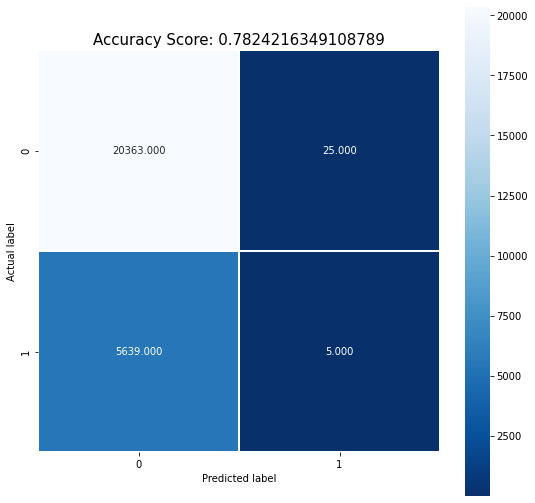

In [ ]:
#show confusion matrix
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Logistic regression has accuracy  score of 78.24 on the dataset.

In [ ]:
# Hyperparameter tuning
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iter = [200,300]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter = max_iter)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
grid_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(scaled_df, train_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.783846 using {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'C': 100}
0.783846 (0.000024) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'C': 100}
0.783846 (0.000024) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 0.1}
0.783846 (0.000024) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'C': 1.0}
0.783846 (0.000024) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'C': 10}
0.783846 (0.000024) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 10}
0.783846 (0.000024) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 1.0}
0.783846 (0.000024) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 300, 'C': 0.01}
0.783846 (0.000024) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 300, 'C': 100}
0.783846 (0.000024) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 0.01}
0.783846 (0.000024) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 20

# SVM

In [8]:
KNN_imputed_trainX = KNN_imputed_trainX[KNN_imputed_testX_df.columns]
KNN_imputed_testX = KNN_imputed_testX_df

In [9]:
#standardize the data for SVM
scaler = StandardScaler()
KNN_imputed_trainX_scaled = scaler.fit_transform(KNN_imputed_trainX)
KNN_imputed_testX_scaled = scaler.transform(KNN_imputed_testX)

KNN_imputed_trainX_scaled_df = pd.DataFrame(KNN_imputed_trainX_scaled, columns=KNN_imputed_trainX.columns, index=KNN_imputed_trainX.index)
print(KNN_imputed_trainX_scaled_df.info)

KNN_imputed_testX_scaled_df = pd.DataFrame(KNN_imputed_testX_scaled, columns=KNN_imputed_testX.columns, index=KNN_imputed_testX.index)
print(KNN_imputed_testX_scaled_df.info)

<bound method DataFrame.info of              age       bmi  ethnicity  ...  d1_sodium_min  d1_wbc_max  d1_wbc_min
115201 -0.119229 -0.042240  -1.884170  ...      -0.078927   -0.392034   -0.300572
5903    0.668470  0.150551   2.787024  ...      -0.150119   -0.420961   -0.262781
68265   0.486693  1.858973  -0.015693  ...      -0.363694   -0.610651   -0.480111
109489  0.365509 -1.298778  -0.015693  ...      -0.150119   -1.021645   -0.950994
14762  -0.664559 -0.812496  -1.884170  ...      -0.150119   -0.015131    0.066886
...          ...       ...        ...  ...            ...         ...         ...
128106 -2.542917 -0.376282  -0.015693  ...      -4.421627   -0.531614   -0.389557
103694  0.001659 -0.887381  -0.015693  ...       1.131334   -0.721303   -0.606887
860     1.516761  0.110271  -0.015693  ...      -0.271145   -0.193070   -0.093746
15795   0.062548  0.267526  -0.015693  ...       1.772060    3.497712    4.226904
121958  0.304917 -0.982155   0.918546  ...       0.277032   -1.132

#### SVM classifier with C=0.1 and a linear kernel



In [ ]:
svm = SVC(C=0.1, kernel='linear', random_state=0)
%time svm.fit(KNN_imputed_trainX_scaled_df, train_y)

In [12]:
pickle.dump(svm, open("svm_classifier.pkl", "wb"))

In [ ]:
diabetes_y_pred = svm.predict(KNN_imputed_testX_scaled_df)
svm_test_accuracy = accuracy_score(test_y, diabetes_y_pred)

In [ ]:
print("Test accuracy for the SVM classifier with C=0.1 and a linear kernel: ",svm_test_accuracy)

#### Hyperparameter search for SVM classifier

In [ ]:
params = {'C': [0.1, 1, 10], 'kernel': ['linear']} 

In [ ]:
randomCV = RandomizedSearchCV(SVC(), params, scoring='accuracy', cv=5, refit='True', random_state=0)

%time randomCV.fit(KNN_imputed_trainX_scaled_df, train_y)
pickle.dump(randomCV, open("randomCV_svm_classifier.pkl", "wb"))

In [ ]:
rand_diabetes_y_pred = randomCV.predict(KNN_imputed_testX_scaled_df)
rand_svm_test_accuracy = accuracy_score(test_y, rand_diabetes_y_pred)

In [ ]:
print("Best parameters resulted from hyperparameter tuning: ",randomCV.best_params_)
print("Best train accuracy score that resulted from the best estimator ",randomCV.best_score_)
print("Test accuracy for the best SVM estimator from hyperparameter search: ",rand_svm_test_accuracy)